In [1]:
import dataclasses
import glob
from natsort import natsorted
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
from collections import defaultdict

def process_method_group(runs):
    records, sequences = [], []
    for run in runs:
        df = pd.read_csv(run.csv_path)
        cols = {c.lower(): c for c in df.columns}
        seq_col = cols.get('query_sequence')
        tm_col = cols.get('negative_tm_score')
        plddt_col = cols.get('negative_plddt')

        df = df.drop_duplicates(subset=seq_col, keep='first')
        df = df[(df[tm_col] <= -0.90) & (df[plddt_col] <= -90.0)]

        n = len(df)
        k = min(run.sample_size, n)

        # シードを固定してサンプリング
        sampled = df.sample(n=k, random_state=42)

        for _, row in sampled.iterrows():
            records.append({
                "method": run.method,
                "label": run.label,
                "tm": -row[tm_col],
                "plddt": -row[plddt_col],
            })
            sequences.append(row[seq_col])
    return records, sequences

def simple_match_ratio(s1, s2):
    n = max(len(s1), len(s2))
    if n == 0:
        return 1.0
    matches = sum(c1 == c2 for c1, c2 in zip(s1, s2))
    return 1 - matches / n

def SimpleMatchMat(records):
    rec_lst = records.copy()
    out = []

    for _ in tqdm(range(len(rec_lst))):
        ref = rec_lst.pop(0)
        sims = [
            simple_match_ratio(ref, r)
            for r in rec_lst
        ]
        out.append(sims)
    return out

def convert_DM_tofull(sparse_matrix):
    n = len(sparse_matrix)
    full = [[0]*n for _ in range(n)]
    for i in range(n):
        for j, v in enumerate(sparse_matrix[i]):
            full[i][i+1+j] = v
            full[i+1+j][i] = v
    return full

@dataclasses.dataclass
class ExperimentRun:
    label: str
    csv_path: str
    method: str
    sample_size: int

csv_files = natsorted(glob.glob('../data/*.csv'))
proposed_runs = [
    ExperimentRun(
        label=f"Proposed_method_{i}",
        csv_path=path,
        method="Proposed-method",
        sample_size=16
    )
    for i, path in enumerate(csv_files)
]

mpnn_runs = [
    ExperimentRun(label="ProteinMPNN (temp=1.0)", csv_path="../data/pMPNN_data/output_mpnn_10.csv", method="pMPNN10", sample_size=384),
    ExperimentRun(label="ProteinMPNN (temp=0.7)", csv_path="../data/pMPNN_data/output_mpnn_07.csv", method="pMPNN07", sample_size=384),
    ExperimentRun(label="ProteinMPNN (temp=0.3)", csv_path="../data/pMPNN_data/output_mpnn_03.csv", method="pMPNN03", sample_size=384),
]

all_runs = proposed_runs + mpnn_runs

runs_by_method = defaultdict(list)
for run in all_runs:
    runs_by_method[run.method].append(run)


sequences_by_method = {}
for method_name, runs in runs_by_method.items():
    print(f"Processing {method_name}")

    records, sequences = process_method_group(runs)
    sequences_by_method[method_name] = sequences

    DM = SimpleMatchMat(sequences)
    fullDM = np.array(convert_DM_tofull(DM))

    out_path = f"./distance_matrix_{method_name}.npy"
    np.save(out_path, fullDM)

for method_name in runs_by_method.keys():
    filename = f"./distance_matrix_{method_name}.npy"
    if not os.path.exists(filename):
        continue
    mat = np.load(filename)
    n = mat.shape[0]
    iu = np.triu_indices(n, k=1)
    mean_d = mat[iu].mean()
    print(f"{method_name}: mean distance = {mean_d:.3f}")


Processing Proposed-method


100%|██████████| 384/384 [00:00<00:00, 1553.39it/s]


Processing pMPNN10


100%|██████████| 384/384 [00:00<00:00, 1479.15it/s]


Processing pMPNN07


100%|██████████| 384/384 [00:00<00:00, 1568.34it/s]


Processing pMPNN03


100%|██████████| 384/384 [00:00<00:00, 1589.49it/s]

Proposed-method: mean distance = 0.716
pMPNN10: mean distance = 0.739
pMPNN07: mean distance = 0.627
pMPNN03: mean distance = 0.385


Reference point for hypervolume: [-0.11249    0.5326087]
Processing ../data/seed01.csv
Processing ../data/seed02.csv
Processing ../data/seed03.csv
Processing ../data/seed04.csv
Processing ../data/seed05.csv
Processing ../data/seed06.csv
Processing ../data/seed07.csv
Processing ../data/seed08.csv
Processing ../data/seed09.csv
Processing ../data/seed10.csv
Processing ../data/seed11.csv
Processing ../data/seed12.csv
Processing ../data/seed13.csv
Processing ../data/seed14.csv
Processing ../data/seed15.csv
Processing ../data/seed16.csv
Processing ../data/seed17.csv
Processing ../data/seed18.csv
Processing ../data/seed19.csv
Processing ../data/seed20.csv
Processing ../data/seed21.csv
Processing ../data/seed22.csv
Processing ../data/seed23.csv
Processing ../data/seed24.csv
Processing ../data/pMPNN_data/output_mpnn_03.csv
Processing ../data/pMPNN_data/output_mpnn_07.csv
Processing ../data/pMPNN_data/output_mpnn_10.csv
Processing ../data/pMPNN_data/output_mpnn_20.csv


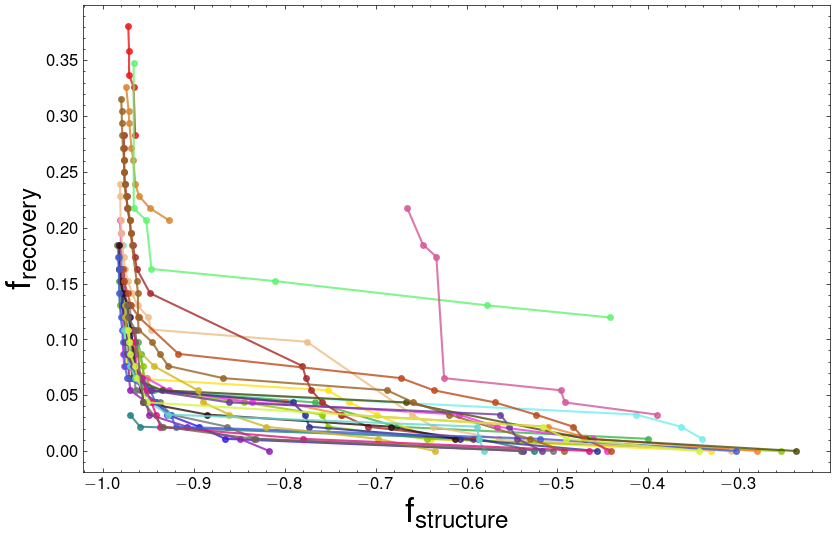

Hypervolume for seed01: 0.449
Hypervolume for seed02: 0.436
Hypervolume for seed03: 0.438
Hypervolume for seed04: 0.443
Hypervolume for seed05: 0.436
Hypervolume for seed06: 0.455
Hypervolume for seed07: 0.425
Hypervolume for seed08: 0.439
Hypervolume for seed09: 0.448
Hypervolume for seed10: 0.422
Hypervolume for seed11: 0.420
Hypervolume for seed12: 0.432
Hypervolume for seed13: 0.445
Hypervolume for seed14: 0.453
Hypervolume for seed15: 0.443
Hypervolume for seed16: 0.422
Hypervolume for seed17: 0.449
Hypervolume for seed18: 0.432
Hypervolume for seed19: 0.446
Hypervolume for seed20: 0.446
Hypervolume for seed21: 0.446
Hypervolume for seed22: 0.439
Hypervolume for seed23: 0.435
Hypervolume for seed24: 0.450
Hypervolume for ProtienMPNN (temp=0.3): 0.214
Hypervolume for ProtienMPNN (temp=0.7): 0.279
Hypervolume for ProtienMPNN (temp=1.0): 0.336
Hypervolume for ProtienMPNN (temp=2.0): 0.264
Hypervolume for Proposed Method: 0.440 ± 0.010


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots  # noqa: F401
import glob
import pandas as pd
from natsort import natsorted

plt.style.use(['science', 'nature'])


def first_front_only(values1, values2):
    assert len(values1) == len(values2) and len(values1) > 0
    n = len(values1)
    dominated = np.zeros(n, int)
    front = []

    for p in range(n):
        for q in range(n):
            if (values1[q] < values1[p] and values2[q] <= values2[p]) or \
               (values1[q] <= values1[p] and values2[q] < values2[p]):
                dominated[p] += 1
        if dominated[p] == 0:
            front.append(p)

    assert len(front) > 0
    return front


csv_files = natsorted(glob.glob('../data/*.csv')) + natsorted(glob.glob('../data/pMPNN_data/*.csv')) + natsorted(glob.glob('../data/random_mutation_data/*.csv'))

palette = sns.color_palette([
        "#3819e6",
        '#3cb44b',
        '#ffe119',
        "#8fc800",
        '#f58231',
        '#911eb4',
        "#72efef",
        '#f032e6',
        "#208181",
        "#edbe89",
        "#A82929",
        "#4D4D08",
        "#323297",
        "#6C736D",
        "#2F1111",
        "#bd4b1a",
        "#435cd8",
        '#9a6324',
        "#d2b720",
        "#63d7cf",
        "#da157e",
        '#6a3d9a',
        '#d2f53c',
        "#736056",
        "#ed1717",
        "#da8530",
        "#60f471",
        "#d55897",
        "#947d7d",
        "#8c69ff",
    ]
)[:len(csv_files)]

plt.rcParams["font.size"] = 25
plt.figure(figsize=(9, 6))

all_points = []

for col, path in zip(palette, csv_files):
    df = pd.read_csv(path)
    cols = {c.lower(): c for c in df.columns}
    tm, wt, seq = cols['negative_tm_score'], cols['recovery'], cols['query_sequence']
    df = df[df[wt] >= 0]
    df = df[df[tm] <= 0]


    df = df.drop_duplicates(subset=seq, keep='first')

    points = df[[tm, wt]].to_numpy()
    points = points[np.argsort(points[:, 0])]
    all_points.append(points)

all_points = np.vstack(all_points)

maxs = np.max(all_points, axis=0)
ref_point = maxs

print(f"Reference point for hypervolume: {ref_point}") 

hypervolume = []

for col, path in zip(palette, csv_files):
    print(f"Processing {path}")
    df = pd.read_csv(path)
    cols = {c.lower(): c for c in df.columns}
    tm, wt, seq = cols['negative_tm_score'], cols['recovery'], cols['query_sequence']
    df = df[df[wt] >= 0]
    df = df[df[tm] <= 0]
    df = df.drop_duplicates(subset=seq, keep='first')

    vals1, vals2 = df[tm].to_numpy(), df[wt].to_numpy()
    idx = first_front_only(vals1, vals2)
    pareto = np.atleast_2d(df.iloc[idx][[tm, wt]].to_numpy())
    pareto = pareto[np.argsort(pareto[:, 0])]

    base = os.path.basename(path)
    if base.startswith("output_mpnn_03"):
        label = "ProtienMPNN (temp=0.3)"
    elif base.startswith("output_mpnn_07"):
        label = "ProtienMPNN (temp=0.7)"
    elif base.startswith("output_mpnn_10"):
        label = "ProtienMPNN (temp=1.0)"
    elif base.startswith("output_mpnn_20"):
        label = "ProtienMPNN (temp=2.0)"
    elif base.startswith("output_mpnn_30"):
        label = "ProtienMPNN (temp=3.0)"
    elif base.startswith("results"):
        label = "Random Mutation"
    else:
        label = os.path.splitext(base)[0]
    plt.plot(
        pareto[:, 0], pareto[:, 1], 'o-', ms=4, lw=1.5,
        alpha=0.8, color=col
    )

    x_min = np.min(pareto[:, 0])
    y_min = np.min(pareto[:, 1])

    A_rect = (ref_point[0] - x_min) * (ref_point[1] - y_min)

    A_under = 0.0
    for i in range(len(pareto) - 1):
        x_i, y_i = pareto[i]
        x_next, _ = pareto[i + 1]
        A_under += (x_next - x_i) * (y_i - y_min)

    area = A_rect - A_under

    hypervolume.append((label, area))

plt.xlabel(r'$\mathrm{f}_{\text{structure}}$')
plt.ylabel(r'$\mathrm{f}_{\text{recovery}}$')
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.show()

for label, area in hypervolume:
    print(f"Hypervolume for {label}: {area:.3f}")

seed_values = [area for label, area in hypervolume if label.startswith("seed")]
mean_area = np.mean(seed_values)
std_area = np.std(seed_values, ddof=1)
print(f"Hypervolume for Proposed Method: {mean_area:.3f} ± {std_area:.3f}")

['../data/seed01.csv', '../data/seed02.csv', '../data/seed03.csv', '../data/seed04.csv', '../data/seed05.csv', '../data/seed06.csv', '../data/seed07.csv', '../data/seed08.csv', '../data/seed09.csv', '../data/seed10.csv', '../data/seed11.csv', '../data/seed12.csv', '../data/seed13.csv', '../data/seed14.csv', '../data/seed15.csv', '../data/seed16.csv', '../data/seed17.csv', '../data/seed18.csv', '../data/seed19.csv', '../data/seed20.csv', '../data/seed21.csv', '../data/seed22.csv', '../data/seed23.csv', '../data/seed24.csv', '../data/pMPNN_data/output_mpnn_03.csv', '../data/pMPNN_data/output_mpnn_07.csv', '../data/pMPNN_data/output_mpnn_10.csv', '../data/pMPNN_data/output_mpnn_20.csv', '../data/pMPNN_data/output_mpnn_30.csv', '../data/random_mutation_data/results.csv']
30 30
Pre-processing ../data/seed01.csv
Pre-processing ../data/seed02.csv
Pre-processing ../data/seed03.csv
Pre-processing ../data/seed04.csv
Pre-processing ../data/seed05.csv
Pre-processing ../data/seed06.csv
Pre-processi

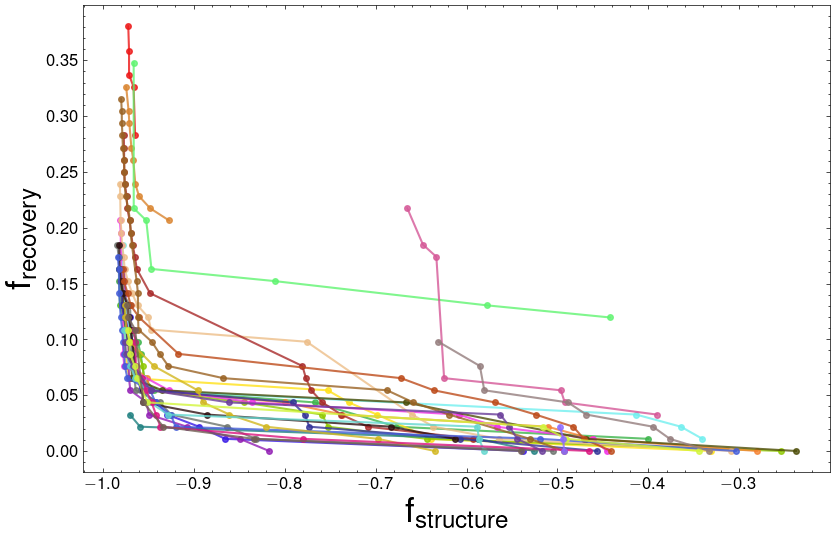

Hypervolume for seed01: 0.271
Hypervolume for seed02: 0.258
Hypervolume for seed03: 0.259
Hypervolume for seed04: 0.263
Hypervolume for seed05: 0.257
Hypervolume for seed06: 0.276
Hypervolume for seed07: 0.247
Hypervolume for seed08: 0.260
Hypervolume for seed09: 0.269
Hypervolume for seed10: 0.243
Hypervolume for seed11: 0.243
Hypervolume for seed12: 0.253
Hypervolume for seed13: 0.265
Hypervolume for seed14: 0.273
Hypervolume for seed15: 0.265
Hypervolume for seed16: 0.243
Hypervolume for seed17: 0.269
Hypervolume for seed18: 0.252
Hypervolume for seed19: 0.267
Hypervolume for seed20: 0.267
Hypervolume for seed21: 0.268
Hypervolume for seed22: 0.260
Hypervolume for seed23: 0.257
Hypervolume for seed24: 0.271
Hypervolume for ProtienMPNN (temp=0.3): 0.071
Hypervolume for ProtienMPNN (temp=0.7): 0.127
Hypervolume for ProtienMPNN (temp=1.0): 0.173
Hypervolume for ProtienMPNN (temp=2.0): 0.137
Hypervolume for ProtienMPNN (temp=3.0): 0.136
Hypervolume for Random Mutation: 0.099
Hypervolume

In [10]:
import os
import numpy as np
import pandas as pd  # 追加
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots  # noqa: F401
import glob
from natsort import natsorted

plt.style.use(['science', 'nature'])


def first_front_only(values1, values2):
    assert len(values1) == len(values2) and len(values1) > 0
    n = len(values1)
    dominated = np.zeros(n, int)
    front = []

    for p in range(n):
        for q in range(n):
            if (values1[q] < values1[p] and values2[q] <= values2[p]) or \
               (values1[q] <= values1[p] and values2[q] < values2[p]):
                dominated[p] += 1
        if dominated[p] == 0:
            front.append(p)

    assert len(front) > 0
    return front


csv_files = natsorted(glob.glob('../data/*.csv')) + natsorted(glob.glob('../data/pMPNN_data/*.csv')) + natsorted(glob.glob('../data/random_mutation_data/*.csv'))
palette = sns.color_palette([
        "#3819e6",
        '#3cb44b',
        '#ffe119',
        "#8fc800",
        '#f58231',
        '#911eb4',
        "#72efef",
        '#f032e6',
        "#208181",
        "#edbe89",
        "#A82929",
        "#4D4D08",
        "#323297",
        "#6C736D",
        "#2F1111",
        "#bd4b1a",
        "#435cd8",
        '#9a6324',
        "#d2b720",
        "#63d7cf",
        "#da157e",
        '#6a3d9a',
        '#d2f53c',
        "#736056",
        "#ed1717",
        "#da8530",
        "#60f471",
        "#d55897",
        "#947d7d",
        "#8c69ff",
    ]
)[:len(csv_files)]

plt.rcParams["font.size"] = 25
plt.figure(figsize=(9, 6))

# --- Step 1: データを読み込み、パレートフロントのみを抽出して一時保存する ---
processed_data = []  # 各ファイルのパレートフロント等の情報を格納
all_pareto_points = [] # 全ファイルのパレートフロント上の点だけを集めるリスト

for col, path in zip(palette, csv_files):
    print(f"Pre-processing {path}")
    df = pd.read_csv(path)
    cols = {c.lower(): c for c in df.columns}
    tm, wt, seq = cols['negative_tm_score'], cols['recovery'], cols['query_sequence']
    
    # フィルタリング
    df = df[df[wt] >= 0]
    df = df[df[tm] <= 0]
    df = df.drop_duplicates(subset=seq, keep='first')

    if len(df) == 0:
        continue

    # パレートフロントの計算
    vals1, vals2 = df[tm].to_numpy(), df[wt].to_numpy()
    idx = first_front_only(vals1, vals2)
    
    # パレート解のみ抽出してソート
    pareto = np.atleast_2d(df.iloc[idx][[tm, wt]].to_numpy())
    pareto = pareto[np.argsort(pareto[:, 0])]
    
    # ラベル生成ロジック
    base = os.path.basename(path)
    if base.startswith("output_mpnn_03"):
        label = "ProtienMPNN (temp=0.3)"
    elif base.startswith("output_mpnn_07"):
        label = "ProtienMPNN (temp=0.7)"
    elif base.startswith("output_mpnn_10"):
        label = "ProtienMPNN (temp=1.0)"
    elif base.startswith("output_mpnn_20"):
        label = "ProtienMPNN (temp=2.0)"
    elif base.startswith("output_mpnn_30"):
        label = "ProtienMPNN (temp=3.0)"
    elif base.startswith("results"):
        label = "Random Mutation"
    else:
        label = os.path.splitext(base)[0]

    # 後で使うために保存
    processed_data.append({
        'label': label,
        'color': col,
        'pareto': pareto,
    })
    
    # Reference Point計算用にパレート点だけを追加
    all_pareto_points.append(pareto)

# --- Step 2: 全パレートフロントの中からReference Point (最悪値) を決定 ---
if all_pareto_points:
    all_pareto_stacked = np.vstack(all_pareto_points)
    # パレートフロントの集合の中で、各軸の最大値（最も悪い値）を取得
    ref_point = np.max(all_pareto_stacked, axis=0)
else:
    # データがない場合のフォールバック（適当な値、もしくはエラー処理）
    ref_point = np.array([0.0, 0.0])

print(f"Reference point (from Pareto fronts): {ref_point}") 


# --- Step 3: プロットとHypervolume計算 ---
hypervolume = []

for item in processed_data:
    label = item['label']
    col = item['color']
    pareto = item['pareto']

    # プロット
    plt.plot(
        pareto[:, 0], pareto[:, 1], 'o-', ms=4, lw=1.5,
        alpha=0.8, color=col
    )

    # Hypervolume計算
    x_min = np.min(pareto[:, 0])
    y_min = np.min(pareto[:, 1])

    # 参照点とパレート解の最小値で作られる矩形面積
    A_rect = (ref_point[0] - x_min) * (ref_point[1] - y_min)

    # パレートフロントの下側の面積を計算（台形積分的なアプローチ）
    A_under = 0.0
    for i in range(len(pareto) - 1):
        x_i, y_i = pareto[i]
        x_next, _ = pareto[i + 1]
        A_under += (x_next - x_i) * (y_i - y_min)

    # 目的の領域の面積
    area = A_rect - A_under

    hypervolume.append((label, area))

plt.xlabel(r'$\mathrm{f}_{\text{structure}}$')
plt.ylabel(r'$\mathrm{f}_{\text{recovery}}$')
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.show()

# 結果出力
for label, area in hypervolume:
    print(f"Hypervolume for {label}: {area:.3f}")

seed_values = [area for label, area in hypervolume if label.startswith("seed")]
if seed_values:
    mean_area = np.mean(seed_values)
    std_area = np.std(seed_values, ddof=1)
    print(f"Hypervolume for Proposed Method: {mean_area:.3f} ± {std_area:.3f}")
else:
    print("No seed files found for statistics.")